# Modèle intelligent pour la détection des masques

Pour ouvrir un dossier dans son Google drive

In [ ]:
# Si travail sur Colabs
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ls

with_mask/  without_mask/


In [ ]:
import numpy as np
import os
import cv2
import PIL.Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pour masquer les messages "d'erreur"
import warnings
warnings.filterwarnings('ignore')

## Partie 1 : Base de données, Analyse et Préparation

### 1.1) Charger et redimensionner les images selon le modèle VGG16

In [ ]:
#import os
# Ouvrir sur Colabs
os.chdir("/content/gdrive/MyDrive/model_dectetion_mask/Mask_Data/")
path = os.getcwd()

# Ouvrir en local si jupyter notebook
#path = './Mask_Data/'
#img = cv2.imread(path)

labels = os.listdir(path) 
print(labels)  

['without_mask', 'with_mask']


In [ ]:
# Lire les images dans les 2 dossiers :
images = []
label = []
for i in labels: 
    path2 = os.path.join(path,i)
    for filename in os.listdir(path2):
        img = cv2.imread(os.path.join(path2,filename))
        imgr = cv2.resize(img,(224,224), interpolation = cv2.INTER_AREA)
        images.append(imgr)
        if i == 'with_mask':
            label.append(1)
        else:
            label.append(0)

In [ ]:
# Transformer les listes en matrice numpy, et standardisé les images
X = np.array(images)/255.0
print(X.shape)

y = np.array(label)
print('************')
print(y.shape)

(1524, 224, 224, 3)
************
(1524,)


### 1.2) Visualiser les images de la classe Avec_Masque et Sans_Masque.

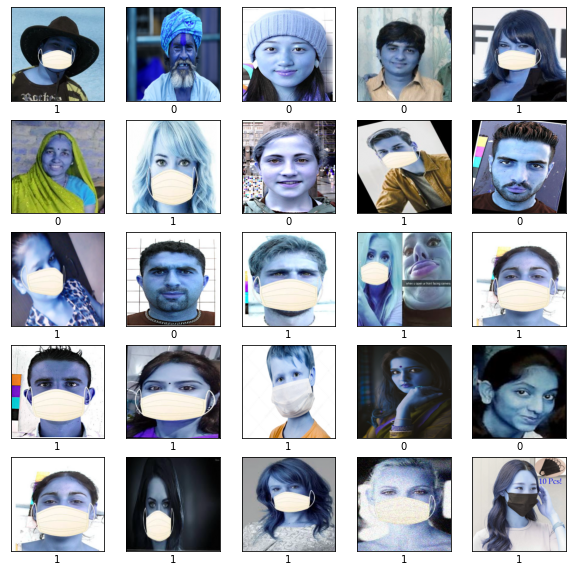

In [ ]:
#import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    nbr = np.random.randint(0, 1524, [1])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[nbr[0]])
    plt.xlabel(y[nbr[0]])
plt.show()


### 1.4) Splitter les données en données d’apprentissage, validation et test

- Séparation sur le jeu catégorisé

In [ ]:
# Séparation du jeu de donnée
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1219, 224, 224, 3), (305, 224, 224, 3), (1219,), (305,))

In [ ]:
# Création du jeu de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1097, 224, 224, 3), (122, 224, 224, 3), (1097,), (122,))

In [ ]:
y_test[:5], y_train[:5], y_val[:5]

(array([1, 0, 0, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 1, 1, 0]))

In [ ]:
# stantadisation de la target y, après séparation, 
# car nous auront besoin des données non catégorisés pour les matrices de confusion
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=None)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=None)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=None)

# autres paramètres : dtype='float32' => ???
y_test_cat[:5], y_train_cat[:5], y_val_cat[:5]

(array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]], dtype=float32), array([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]], dtype=float32))

  ### -----------------------------------------------------------------------------------------------------------------

## ​Partie 2 : Architecture CNN sur Tensorflow

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
#from keras.optimizer_v2 import adam as adam_v2
#from keras import backend as K


Cette deuxième partie est réservée pour développer le modèle CNN sur tensorflow, et lancée par la suite l’apprentissage de CNN.

- Au début, il faut préparer et appliquer la Data Augmentation sur les données d’apprentissage.

- Charger et configurer le modèle VGG16 pour l’application souhaitée.

- Appeler le ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (from keras.callbacks import ModelCheckpoint)

- Lancer un apprentissage en utilisant les données d’apprentissage et les données de validation avec un historique.

- Tracer les courbes d’accuracy et d’erreur de train et validation.

- Calculer l’accuracy et la matrice de confusion sur les données de test.


- **Data Augmentation sur les données d’apprentissage sur mon train**

In [ ]:
# Data Augmentation sur les données d’apprentissage CATEGORISE
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

X_train.shape

(1097, 224, 224, 3)

- **modèle VGG16**

In [ ]:
#from keras.applications.vgg16 import VGG16
# Modèle VGG16, 
# include_top = si True tu gardes toutes les couches du VGG16
# alors qu'on et on ne créer pas nos propres couches à la fin pour faire la classification
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False


=> Explication du VGG16 et des hyperparams
tf.keras.applications.VGG16(
    include_top=False, # True si tu gardes toutes les couches du VGG16, false c'est sans le flatten, le dense et softmax
    weights="imagenet", # j'ai besoin des poids de imagenet
    input_tensor=None,
    input_shape=None, # par défaut il propose 224x224, je peux changer, et à préciser si 
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


- **Ajouter des couches denses sur le dessus des couches de convulution du VGG16**

In [ ]:
# num_classes = nombre de classe de la target, ici 2 : avec ou sans masque
num_classes = 2

model = tf.keras.Sequential([
    # Ajout du modèle VGG16
    base_model, 
    #Flatten(name='flatten')(CNN1.outpout), 
    Flatten(), 
    Dense(4096,activation='relu'),
    Dense(4096, activation='relu'),
    Dense(num_classes, activation='softmax')   
    # Softmax pour arrondir la classe, 
    # Sigmoid si dans la dernière couche il y 1 neuronne
    # Car à la base c'était fait pour 1 neuronne pour dire : oui ou non / 0 ou 1 / ... en sortie (1) => Sigmoïde, 
    # Maintenant ça peut être pour dire : oui, non, possible, peut-être / 1, 2, 3, 4 ou  5 / ...  plusieurs sortie => sofmax
    # Dans notre jeu de donnée, comme on est sur une classification binaire, on peut faire les 2,
    # Sauf que nous avons catégorisé la target, on est donc en softmax (to_categorical)
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_8 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________


ModelCheckpoint => sauvegarde la meilleur epoch parmis les différents
model.fit(    param callback = 'Checkpoint')
ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (from keras.callbacks import ModelCheckpoint

- **Compiler le modèle**

In [ ]:
# => si la target est catégorisée :  
model.compile(optimizer='adam', 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['acc'])
# !!!! si metrics = acc => dans ton checkpoint doit être monitor='val_acc'
# !!!! si metrics = accuracy => dans ton checkpoint doit être monitor='val_accuracy'

#=> si la target est NON catégorisée
#model.compile(optimizer='adam', 
#              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#              metrics=['acc'])

- **Entraîner le modèle, en sauvegardant les poids de la meilleur époque**

In [ ]:
# point de sauvegarde du modèle *.h5
checkpoint_filepath = '/content/gdrive/MyDrive/model_dectetion_mask/model_mask.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # => True si sauvegarde des poids, ici sauvegarde du modèle, donc Fals
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [ ]:
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(datagen.flow(X_train, y_train_cat), 
                    epochs=10, 
                    validation_data = (X_val, y_val_cat), 
                    callbacks=[model_checkpoint_callback])


Epoch 1/10
35/35 [==============================] - 26s 723ms/step - loss: 1.1723 - acc: 0.8970 - val_loss: 0.2368 - val_acc: 0.9098
Epoch 2/10
35/35 [==============================] - 20s 571ms/step - loss: 0.0346 - acc: 0.9881 - val_loss: 0.5269 - val_acc: 0.8852
Epoch 3/10
35/35 [==============================] - 34s 969ms/step - loss: 0.0192 - acc: 0.9954 - val_loss: 0.0900 - val_acc: 0.9754
Epoch 4/10
35/35 [==============================] - 21s 597ms/step - loss: 0.0378 - acc: 0.9936 - val_loss: 0.4599 - val_acc: 0.8689
Epoch 5/10
35/35 [==============================] - 20s 576ms/step - loss: 0.0255 - acc: 0.9936 - val_loss: 0.2069 - val_acc: 0.9344
Epoch 6/10
35/35 [==============================] - 18s 507ms/step - loss: 0.0231 - acc: 0.9945 - val_loss: 0.3608 - val_acc: 0.9262
Epoch 7/10
35/35 [==============================] - 18s 510ms/step - loss: 0.0218 - acc: 0.9927 - val_loss: 0.2054 - val_acc: 0.9344
Epoch 8/10
35/35 [==============================] - 29s 826ms/step - 

- **Évaluer le modèle**

35/35 - 11s - loss: 0.1333 - acc: 0.9635 - 11s/epoch - 300ms/step


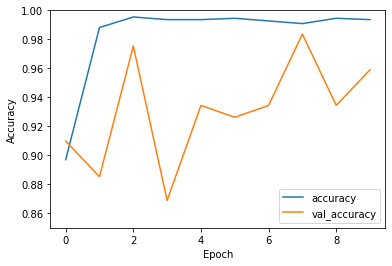

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_train, y_train_cat, verbose=2)

In [ ]:
test_acc

0.9635369181632996

35/35 - 10s - loss: 0.1333 - acc: 0.9635 - 10s/epoch - 298ms/step


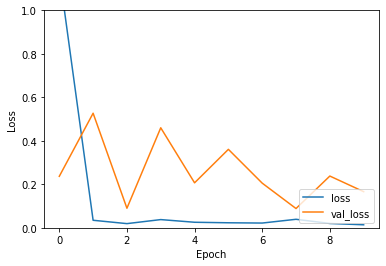

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_train, y_train_cat, verbose=2)

In [ ]:
test_loss

0.13329358398914337

- **Téléchargement du modèle**

In [ ]:
# Si travail sur Colabs
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Si travail sur Colabs
filepath = '/content/gdrive/MyDrive/model_dectetion_mask/model_mask.h5'

loaded_model = keras.models.load_model(filepath)

- **Voyons ce que donne sur le jeu de test**

In [ ]:
y_prob = loaded_model.predict(X_test)
y_pred = y_prob.argmax(axis = -1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Précision du modèle : ', accuracy_score(y_test, y_pred))
print('\nMatrice de confusion : \n', confusion_matrix(y_test, y_pred))
print('\nReport : \n', classification_report(y_test, y_pred))

Précision du modèle :  0.9737704918032787

Matrice de confusion : 
 [[156   7]
 [  1 141]]

Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       163
           1       0.95      0.99      0.97       142

    accuracy                           0.97       305
   macro avg       0.97      0.98      0.97       305
weighted avg       0.97      0.97      0.97       305



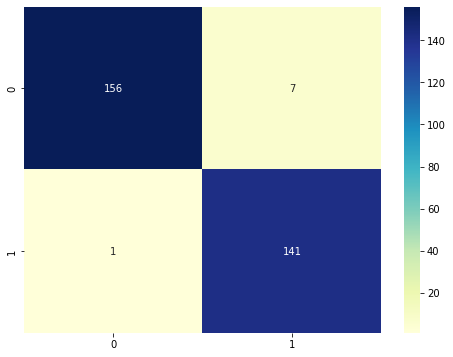

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="YlGnBu")
plt.show()

=> Le modèle obtient de bons résultats sur le jeu test, et ne semble pas overfité